<a href="https://colab.research.google.com/github/NitayAmiel/HW_AI_Course/blob/main/HW4_AI_course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set up


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
HOME = "/content/drive/MyDrive/testing123/drone_data"

# NOTICE: Adjust the path above accordingly to your files' location

%cd {HOME}


# **Preproccessing the Data**

In [ ]:
import os
import random
from PIL import Image
import tensorflow as tf
from keras.preprocessing import image
import numpy as np
from IPython.display import display

DRONE = 1
NOT_A_DRONE = 0

# Seperating between the images and the annotations
images = [image for image in os.listdir(HOME) if image[image.rfind(".")+1:] == "jpg"]
labels = [label for label in os.listdir(HOME) if label[label.rfind(".")+1:] == "txt"]

drone_images = []
not_drone_images =[]

for index,label in enumerate(labels):
  # Just for following the runtime (running this cell takes 2 minutes approx.)
  if index % 50 == 0:
    print(f' {index = }')

  # Reading the coordinates from the annotations, Remember: the labels are as YOLO V8 format.
  with open(label) as label_file:
    content = label_file.read()
    lst = content.split(" ")
    lst[4] = lst[4][:-1] #removing \n
    x_center, y_center, width, height = float(lst[1]), float(lst[2]),float(lst[3]),float(lst[4])

    # The coordinates list is in this order : x_left, y_top, x_right, y_down
    coordinates = [x_center - width/2, y_center - height/2 ,x_center + width/2, y_center + height/2]
    image_drone = Image.open(images[index])
    pixels_width, pixels_height = image_drone.size

    # Represnting the coordinates as number of pixels, and not as float in [0,1]
    for i in range(4):
      coordinates[i] = int(coordinates[i]*pixels_width) if i%2 == 0 else int(coordinates[i]*pixels_height)

    # Cropping , converting to gray, reshaping, and then saving the binding box with respect lebel( a drone)
    bnbox = image_drone.crop(tuple(coordinates))
    grayscale_box = bnbox.convert("L")
    grayscale_box = grayscale_box.resize((28,28))
    grayscale_box = image.img_to_array(grayscale_box)
    reshaped_img_array = np.reshape(grayscale_box, (28, 28, 1))
    drone_images.append((reshaped_img_array, DRONE))

    # Creating a random 28*28 picture, converting it to gray, reshaping it, and then saving with respect lebel(not a drone)
    x_random = random.randint(0,pixels_width-28)
    y_random = random.randint(0,pixels_height-28)
    not_drone_image = image_drone.crop((x_random, y_random,x_random+28, y_random+28 ))
    not_drone_image = not_drone_image.convert("L")
    not_drone_image = image.img_to_array(not_drone_image)
    not_drone_image = np.reshape(not_drone_image, (28, 28, 1))
    not_drone_images.append((not_drone_image, NOT_A_DRONE))




displaying some images from the data set

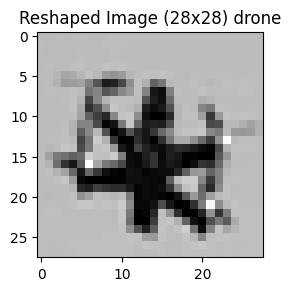

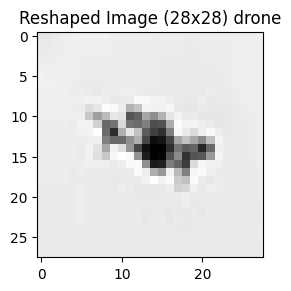

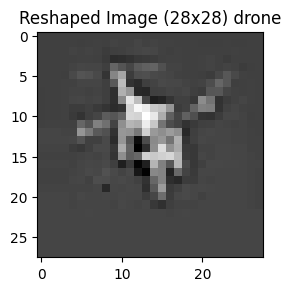

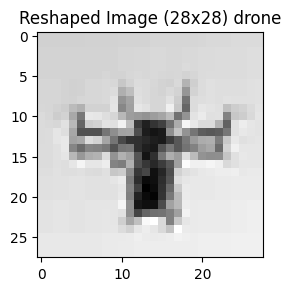

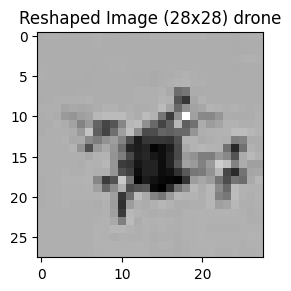

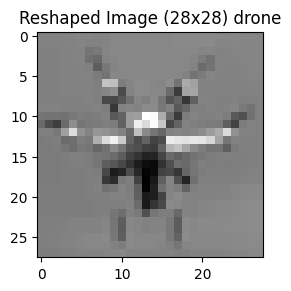

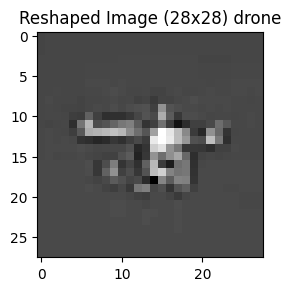

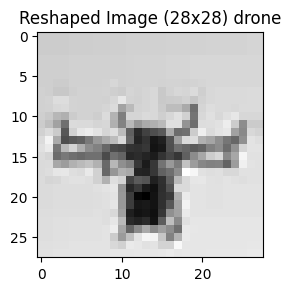

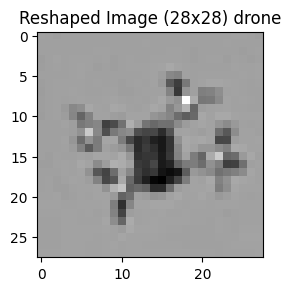

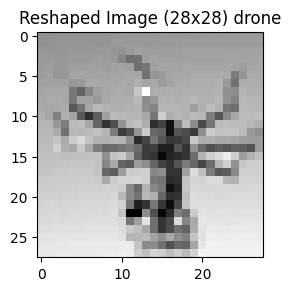

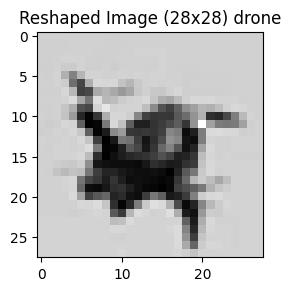

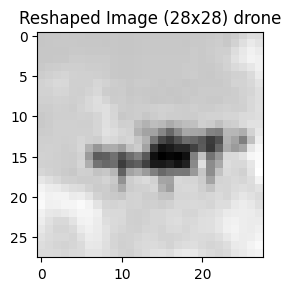

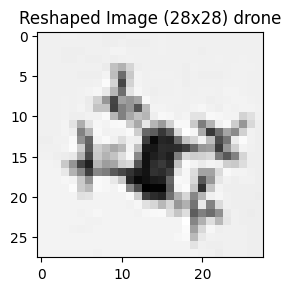

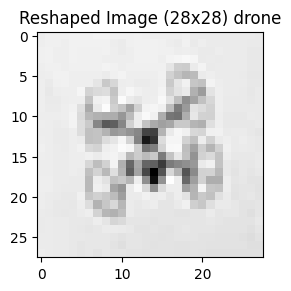

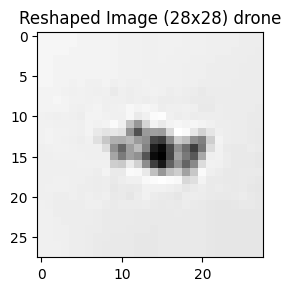

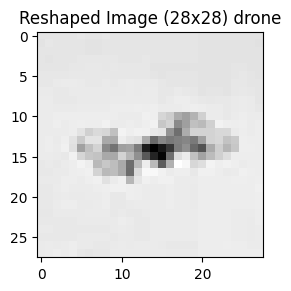

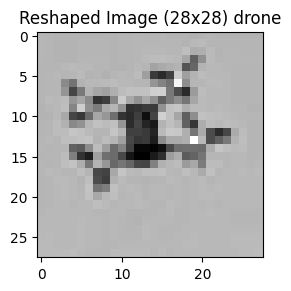

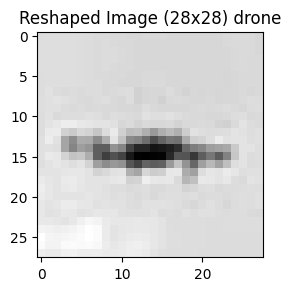

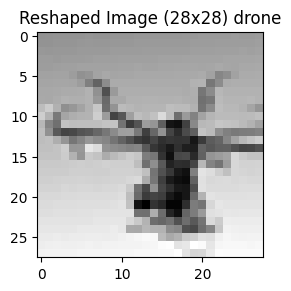

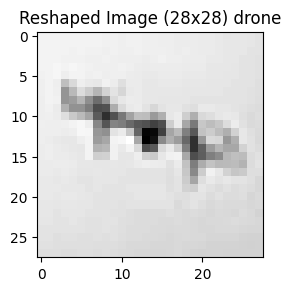

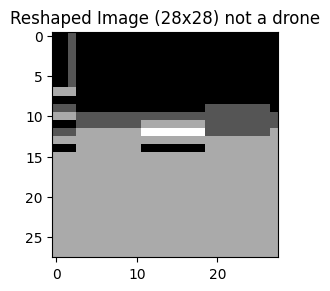

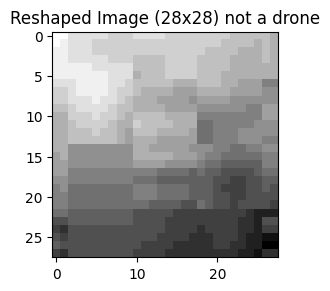

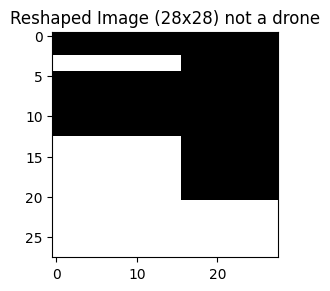

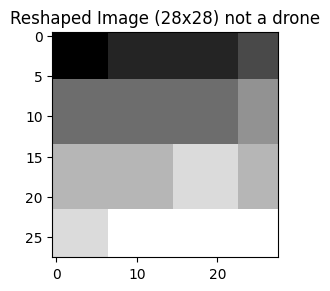

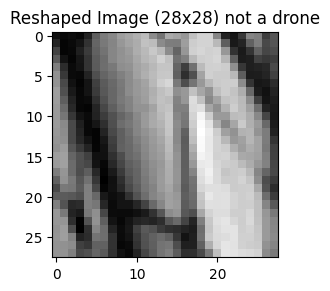

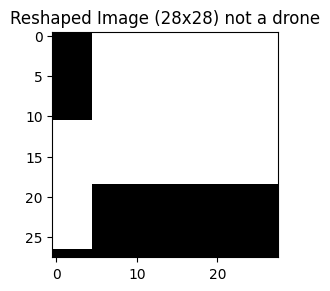

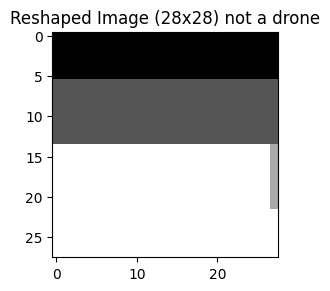

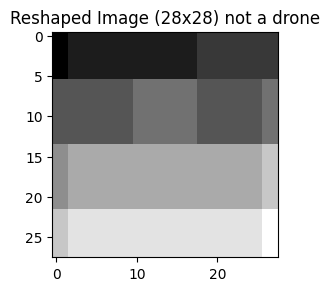

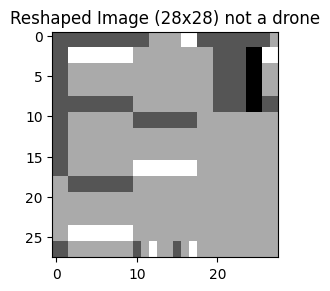

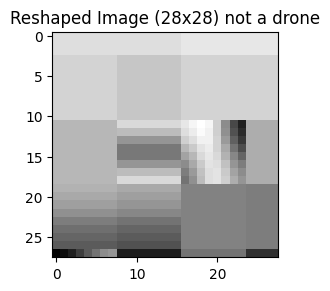

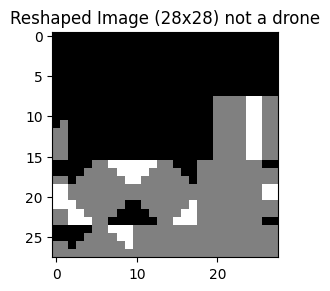

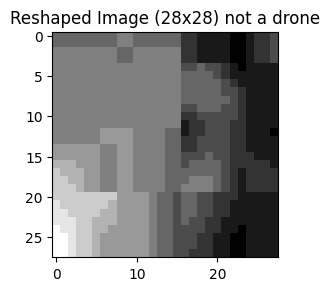

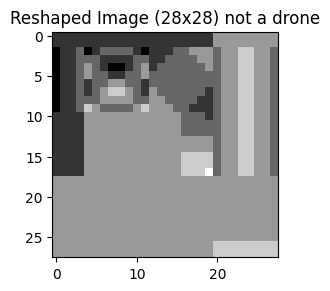

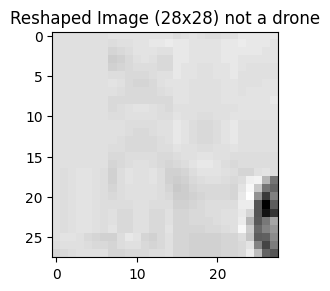

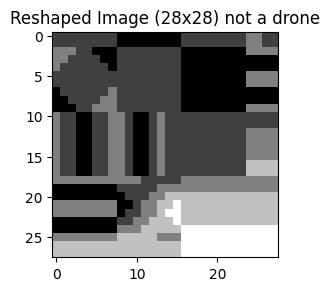

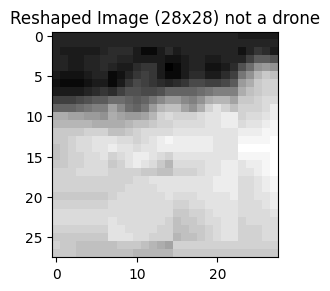

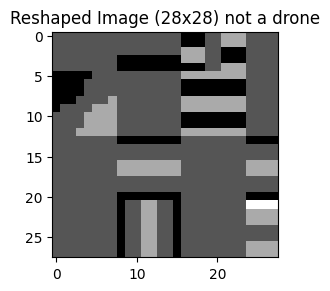

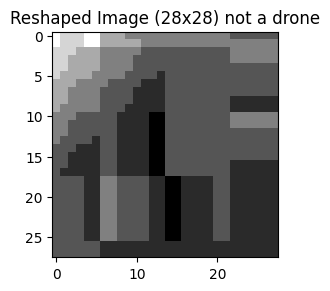

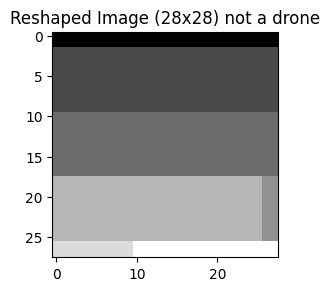

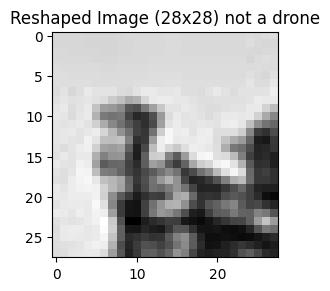

In [4]:
import matplotlib.pyplot as plt

# Write here how many pictures you wish to display from every data set
number_of_images_to_display = 20

counter = 0
for img in drone_images:
  counter += 1
  if counter > number_of_images_to_display:
    break
  plt.subplot(1, 2, 2)
  plt.imshow(img[0][:, :, 0], cmap='gray')
  plt.title('Reshaped Image (28x28) drone')
  plt.show()


counter = 0
for img in not_drone_images:
  counter += 1
  if counter > number_of_images_to_display:
    break

  plt.subplot(1, 2, 2)
  plt.imshow(img[0][:, :, 0], cmap='gray')
  plt.title('Reshaped Image (28x28) not a drone')
  plt.show()

# converting to TensorFlow Datasets


In [5]:
import tensorflow as tf

# Adjust by your choice, to how to seperate the data (train and test)
split_ratio = 0.85

data_list = drone_images + not_drone_images
random.shuffle(data_list)
split_point = int(len(data_list)*split_ratio)
train_list = data_list[:split_point]
test_list = data_list[split_point:]


# Function to create a generator
def data_generator(list_of_data):
    for image_array, label in list_of_data:
        yield image_array, label

# Define the types and shapes of the elements in each tuple
element_spec = (
    tf.TensorSpec(shape=(28, 28, 1), dtype=tf.float32),
    tf.TensorSpec(shape=(), dtype=tf.int32)
)

# Create the TensorFlow dataset
train_dataset = tf.data.Dataset.from_generator(lambda : data_generator(train_list), output_signature=element_spec)
test_dataset = tf.data.Dataset.from_generator(lambda : data_generator(test_list), output_signature=element_spec)


# Preprocess the data, it might take a while
train_images = np.array([img[0]  for img in train_dataset], dtype=np.float32)
test_images = np.array([img[0]  for img in test_dataset], dtype=np.float32)
train_labels = np.array([img[1]  for img in train_dataset], dtype=np.int32)
test_labels = np.array([img[1]  for img in test_dataset],dtype=np.int32)

# Converting the pixels to number in [0,1]
train_images = train_images.reshape((len(train_images), 28, 28, 1)).astype('float32') / 255
test_images = test_images.reshape((len(test_images), 28, 28, 1)).astype('float32') / 255


**size of data set**

 the data is perfectly balnced, 50% drones and 50% not


In [6]:
print(len(data_list)) # the size of the entire data(including the random pictures)

8140


# creting a model


In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical


# Define your model
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28, 1)),
    layers.Dense(128, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification, output a probability
])


# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # Binary crossentropy for binary classification
              metrics=['accuracy'])


# Display a summary of the model architecture, uneccessery - you can write it as a comment
model.summary()


# Defining the batch and the epochs
batch_size = 128
epochs = 500


# Train the model
model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               100480    
                                                                 
 dense_4 (Dense)             (None, 16)                2064      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 102561 (400.63 KB)
Trainable params: 102561 (400.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
55/55 [==============================] - 1s 3ms/step - loss: 0.6379 - accuracy: 0.6858
Epoch 2/500
55/55 [============================

**evaluate the model**

In [11]:
#Evaluate the model on a test dataset if available
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy}')

39/39 [==============================] - 0s 2ms/step - loss: 0.2113 - accuracy: 0.9517
Test Accuracy: 0.9516789317131042


**example of prediction**

1/1 [==============================] - 0s 57ms/step


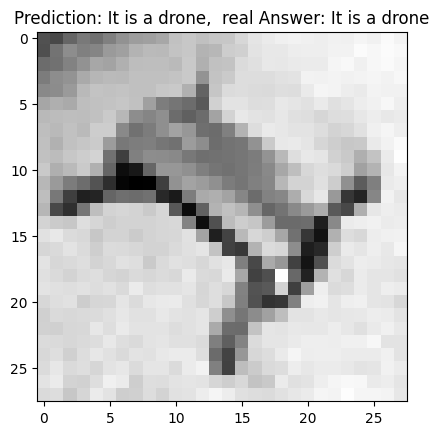

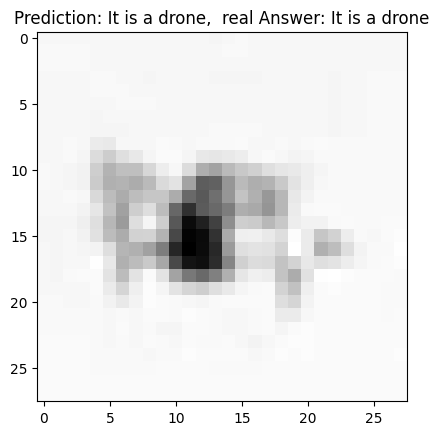

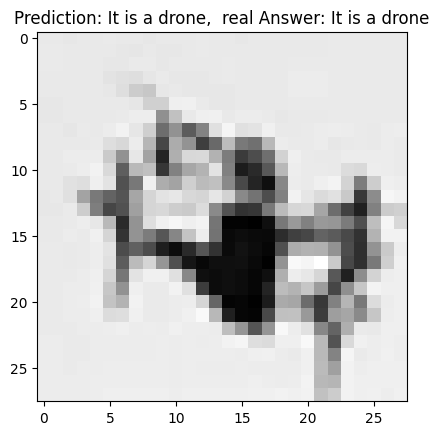

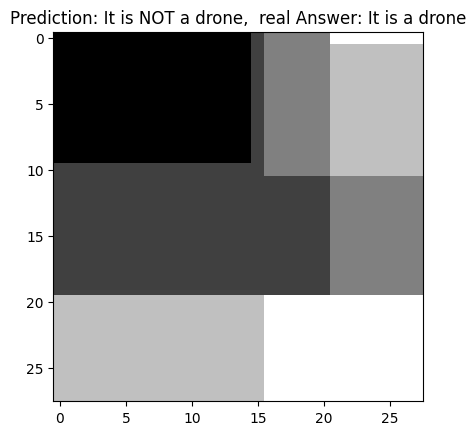

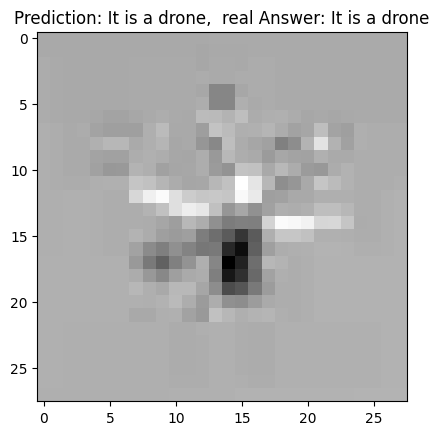

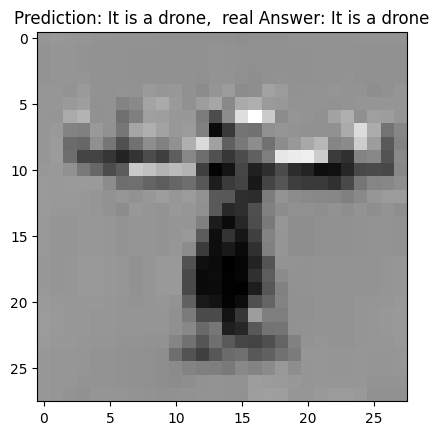

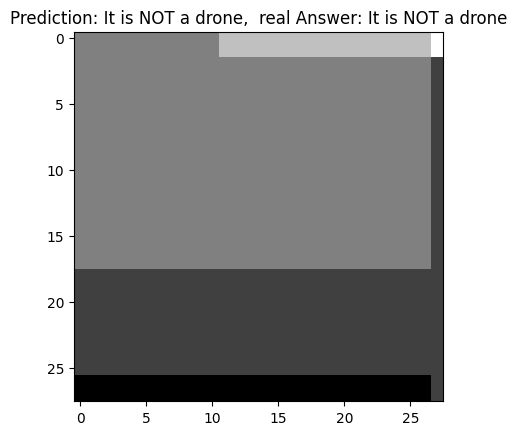

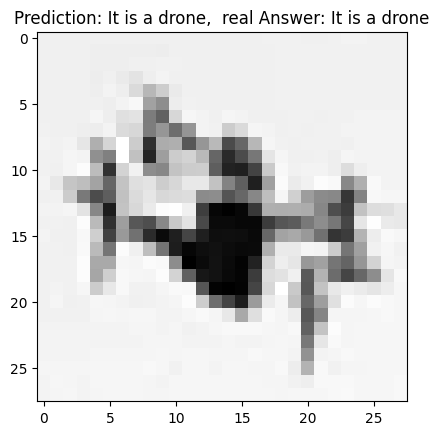

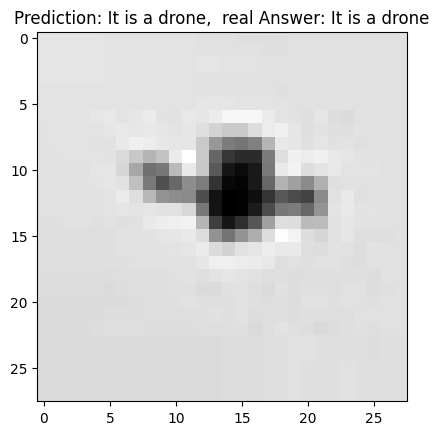

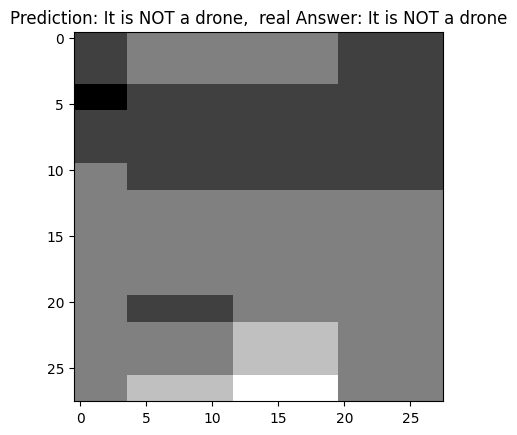

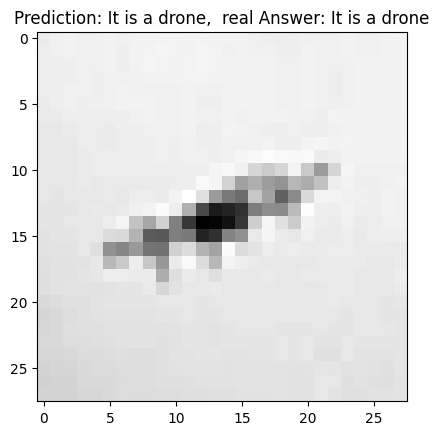

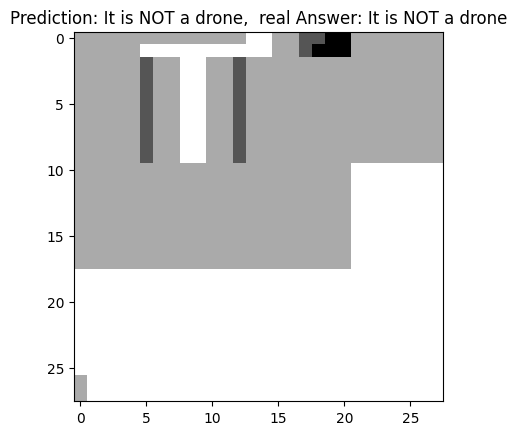

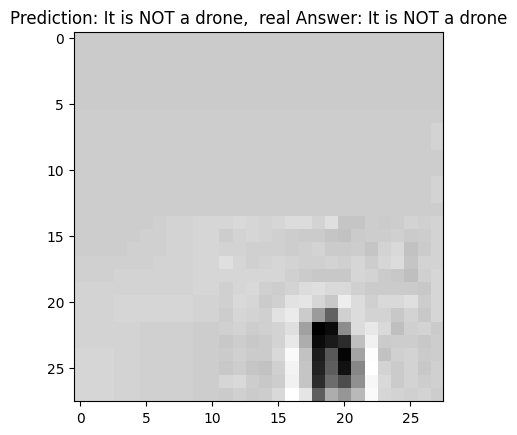

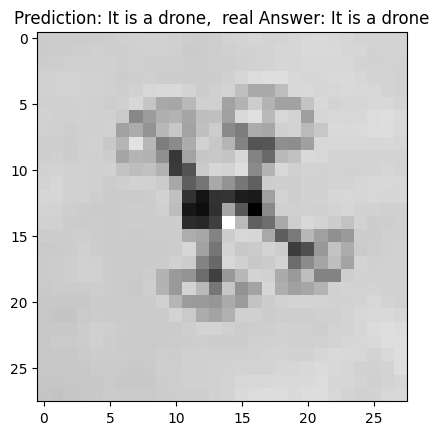

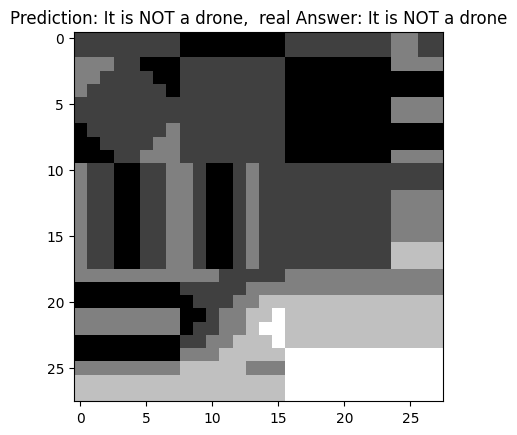

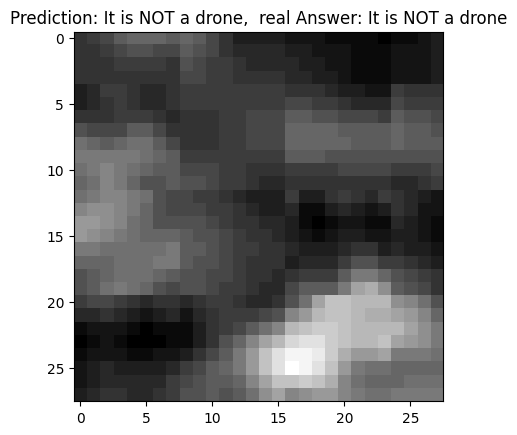

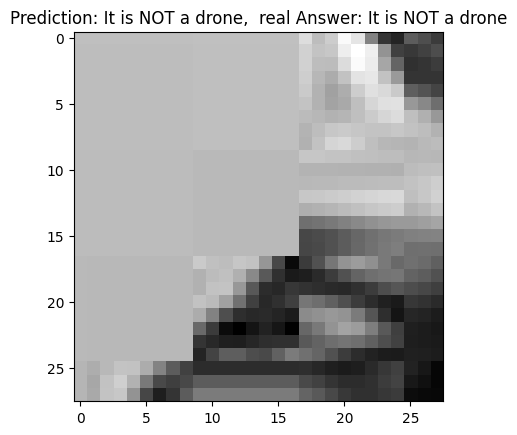

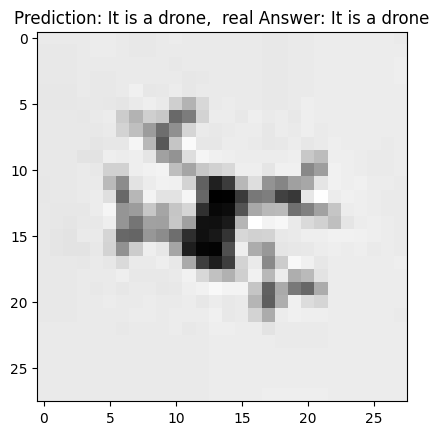

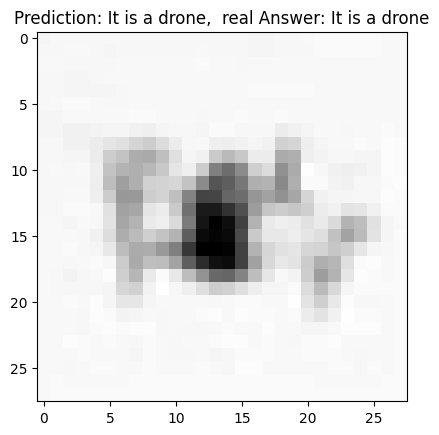

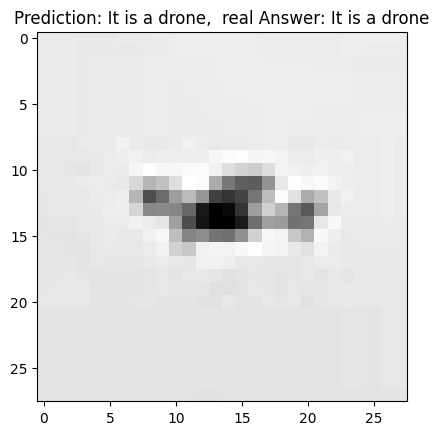

In summary we have 19 good predictions, out from 20


In [12]:
import matplotlib.pyplot as plt
number_of_pictures_to_predict = 20

new_data = test_images[: number_of_pictures_to_predict]

predictions = model.predict(new_data)

# Convert predictions to binary (0 or 1) based on a threshold (e.g., 0.5), you can adjust for more or less surency
binary_predictions = (predictions > 0.5).astype(int)

counter = 0
# Plot the images along with their predictions
for i in range(len(new_data)):
    plt.imshow(new_data[i].reshape(28, 28), cmap='gray')
    real = "It is a drone" if test_labels[i] == DRONE else "It is NOT a drone"
    predict = "It is a drone" if binary_predictions[i][0] == DRONE else "It is NOT a drone"
    if real == predict:
      counter += 1
    plt.title(f'Prediction: {predict},  real Answer: {real}')
    plt.show()

print(f"In summary we have {counter} good predictions, out from {number_of_pictures_to_predict}")